Step 1:  Joining patients.csv and appointments.csv and keeping only matching records.

In [159]:
#Importing Patients.csv and appointments.csv from git and storing them in separate pandas dataframes

import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/patients.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
patients = pd.read_csv(io.StringIO(s.decode('utf-8')))

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/appointments.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
appointments = pd.read_csv(io.StringIO(s.decode('utf-8')))


In [160]:
#Joining and keeping only matching records
patient_appt = patients.merge(appointments, how='inner', left_on='patient_id', right_on='id')

In [161]:
#Dropping Id variable since it is already contained in Patient_Id column
patient_appt.drop('id',axis=1,inplace=True)

In [162]:
#Examining variables for missing values.  None found!
patient_appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299900 entries, 0 to 299899
Data columns (total 13 columns):
patient_id                  299900 non-null int64
age                         299900 non-null int64
gender                      299900 non-null object
diabetes                    299900 non-null int64
alcoholism                  299900 non-null int64
hypertension                299900 non-null int64
handicap                    299900 non-null int64
smokes                      299900 non-null int64
tuberculosis                299900 non-null int64
appointment_registration    299900 non-null object
appointment_date            299900 non-null object
status                      299900 non-null object
sms_reminder                299900 non-null object
dtypes: int64(8), object(5)
memory usage: 32.0+ MB


Step 2a: Derive a new variable day_of_week to provide the day of the week the appointment was scheduled for. 

In [163]:
#Extracting weekday name from appointment date
import dateutil.parser
def parse_full_date(row):
    yourdate = pd.to_datetime(dateutil.parser.parse(row['appointment_date']))
    return yourdate

patient_appt['day_of_week'] = patient_appt.apply(parse_full_date,axis=1)
patient_appt['day_of_week'] = patient_appt['day_of_week'].dt.weekday_name

Step 2b: Take a frequency count of day_of_week to examine what day of the week patients are most
likely to not show up for an appointment.

In [164]:
#Patients are not likely to show up mostly on Mondays.
patient_appt[patient_appt['status']=='No-Show']['day_of_week'].value_counts()

Monday       19044
Wednesday    18910
Tuesday      18145
Thursday     17844
Friday       16239
Saturday       513
Sunday           1
Name: day_of_week, dtype: int64

Step 3: Bin the ages into 10 groups and plot status by age.

In [165]:
#Binning ages into 10 groups.
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
group_names = ['<10', '10-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '>90']
age_group = pd.cut(patient_appt['age'], bins, labels=group_names)
patient_appt['age_group'] = pd.cut(patient_appt['age'], bins, labels=group_names)

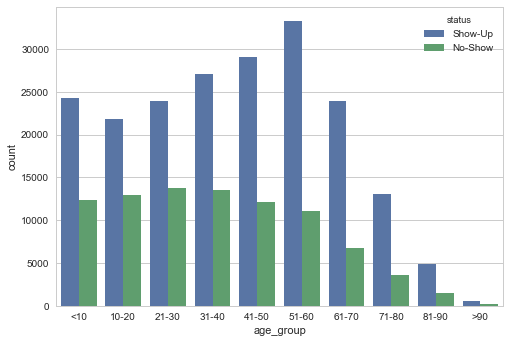

In [166]:
#Plotting status by age groups.
%matplotlib inline
import seaborn as sns

sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="age_group", hue="status", data=patient_appt, order=group_names);

Step 4: Build a basic model to predict whether a patient shows up for their appointment.

In [167]:
#Converting patient_id column to string.
patient_appt['patient_id'] = patient_appt['patient_id'].astype(str)

#Converting target to numeric
patient_appt['status'] = patient_appt['status'].apply(lambda x: 1 if x=='No-Show' else 0)

In [168]:
#Frequency counts of number of show-up and no-shows.  No-show is 1 and show-up is 0.
patient_appt.status.value_counts()

0    209204
1     90696
Name: status, dtype: int64

In [169]:
#Analyzing summary statistics of the variables 
patient_appt.describe(include='all')

,patient_id,age,gender,diabetes,alcoholism,hypertension,handicap,smokes,tuberculosis,appointment_registration,appointment_date,status,sms_reminder,day_of_week,age_group
count,299900,299900.000000,299900,299900.000000,299900.000000,299900.000000,299900.000000,299900.000000,299900.000000,299900,299900,299900.000000,299900,299900,289546
unique,299897,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,295326,534,NaN,2,7,10
top,204731,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-15T14:19:34Z,2014-10-22T00:00:00Z,NaN,Yes,Wednesday,51-60
freq,2,NaN,200445,NaN,NaN,NaN,NaN,NaN,NaN,9,759,NaN,171390,63473,44340
mean,NaN,37.808173,NaN,0.077973,0.025015,0.215899,0.020520,0.052374,0.000450,NaN,NaN,0.302421,NaN,NaN,NaN
std,NaN,22.808943,NaN,0.268129,0.156171,0.411445,0.155929,0.222781,0.021212,NaN,NaN,0.459307,NaN,NaN,NaN
min,NaN,-2.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,38.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
75%,NaN,56.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN


In [280]:
#There are 3 patients who have more than 1 record in the data. 204731, 613126, 400712.
patient_appt.patient_id.value_counts()

204731    2
613126    2
400712    2
217654    1
411723    1
743791    1
383819    1
414943    1
696877    1
117883    1
144622    1
120784    1
453871    1
825337    1
522467    1
936273    1
606858    1
408892    1
903987    1
991986    1
463056    1
940999    1
874075    1
689122    1
254251    1
314486    1
201597    1
204812    1
132161    1
959000    1
         ..
669285    1
414548    1
146609    1
234505    1
165263    1
431911    1
286706    1
330844    1
693383    1
790034    1
729467    1
276693    1
392556    1
188925    1
283988    1
589989    1
998744    1
946532    1
672848    1
156574    1
845212    1
658524    1
301099    1
174632    1
749558    1
116546    1
560810    1
720853    1
977009    1
569574    1
Name: patient_id, Length: 299897, dtype: int64

In [278]:
#analysing entries of one of the 3 patients with multiple appointments.
patient_appt[patient_appt['patient_id']=='400712']

,patient_id,age,gender,diabetes,alcoholism,hypertension,handicap,smokes,tuberculosis,appointment_registration,appointment_date,status,sms_reminder,day_of_week,age_group
128812,400712,36,M,0,0,0,0,0,0,2015-03-25T10:26:31Z,2015-03-31T00:00:00Z,0,Yes,Tuesday,31-40
128813,400712,36,M,0,0,0,0,0,0,2014-09-10T10:54:00Z,2014-09-11T00:00:00Z,0,No,Thursday,31-40


In [170]:
#From the descriptive statistics values, we find that handicap variable has 5 levels.  So we convert it to str.
patient_appt.handicap.value_counts()
patient_appt['handicap'] = patient_appt['handicap'].astype(str)

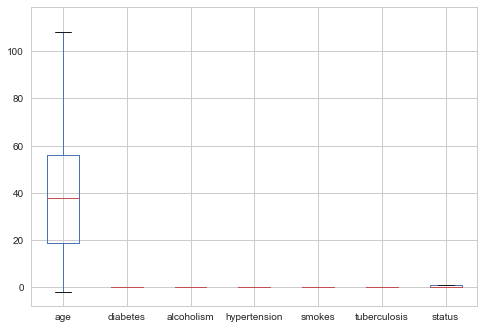

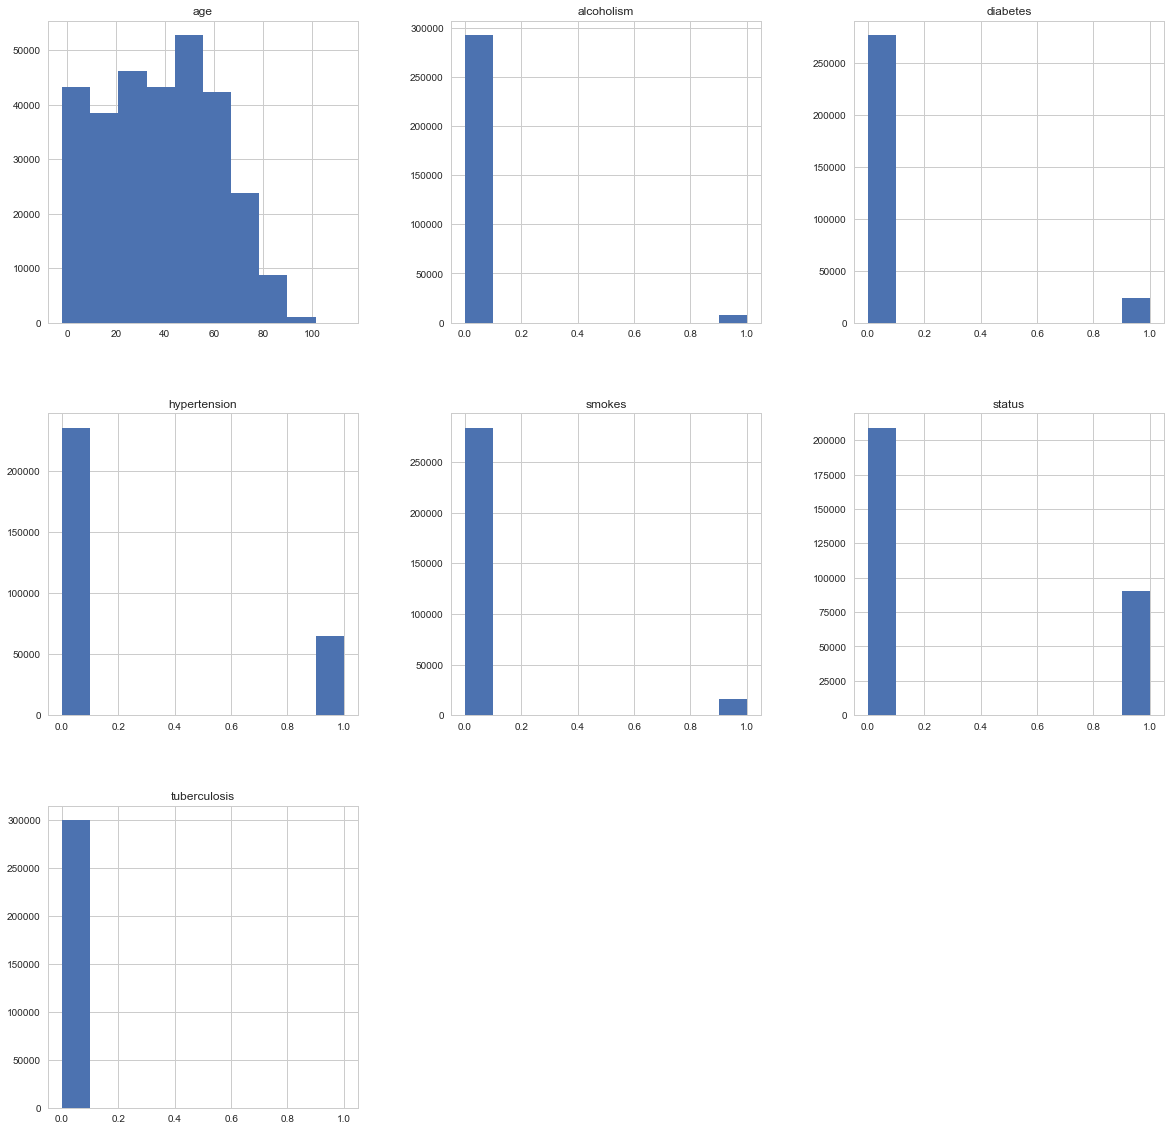

In [171]:
#Seeing distributions of variables for outliers, skewness etc.
import matplotlib.pyplot as plt
patient_appt.boxplot()
patient_appt.hist(figsize=(20,20));

In [281]:
#from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
#Separating independent (X) and dependent variable(Y).
X = patient_appt[['age_group','gender','diabetes','alcoholism','hypertension','handicap','smokes','tuberculosis','sms_reminder','day_of_week']]
y = patient_appt['status']
#Imputing variables with median incase there are missing values in future.  Not the best technique, but just for time being.
X_d = X.fillna(X.median())
#Getting binary dummy variables for categorical columns.
X_d = pd.get_dummies(X_d)
#d = defaultdict(LabelEncoder)
#X_d = X_d.apply(lambda x: d[x.name].fit_transform(x))
X_d.head()

,diabetes,alcoholism,hypertension,smokes,tuberculosis,age_group_10-20,age_group_21-30,age_group_31-40,age_group_41-50,age_group_51-60,...,handicap_4,sms_reminder_No,sms_reminder_Yes,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [282]:
X_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299900 entries, 0 to 299899
Data columns (total 31 columns):
diabetes                 299900 non-null int64
alcoholism               299900 non-null int64
hypertension             299900 non-null int64
smokes                   299900 non-null int64
tuberculosis             299900 non-null int64
age_group_10-20          299900 non-null uint8
age_group_21-30          299900 non-null uint8
age_group_31-40          299900 non-null uint8
age_group_41-50          299900 non-null uint8
age_group_51-60          299900 non-null uint8
age_group_61-70          299900 non-null uint8
age_group_71-80          299900 non-null uint8
age_group_81-90          299900 non-null uint8
age_group_<10            299900 non-null uint8
age_group_>90            299900 non-null uint8
gender_F                 299900 non-null uint8
gender_M                 299900 non-null uint8
handicap_0               299900 non-null uint8
handicap_1               299900 non-null ui

In [283]:
#Check for variable correlation
corr = X_d.corr()
corr

,diabetes,alcoholism,hypertension,smokes,tuberculosis,age_group_10-20,age_group_21-30,age_group_31-40,age_group_41-50,age_group_51-60,...,handicap_4,sms_reminder_No,sms_reminder_Yes,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
diabetes,1.000000,0.020549,0.424375,0.038589,0.001450,-0.100616,-0.098485,-0.073393,-0.007164,0.103941,...,-0.001761,0.032637,-0.032637,-0.003404,0.008869,0.013422,-0.001301,-0.011157,0.005684,-0.002410
alcoholism,0.020549,1.000000,0.069918,0.385861,0.045923,-0.051296,-0.022026,0.025728,0.062175,0.059842,...,-0.000970,0.019171,-0.019171,0.002434,0.004353,0.000048,-0.000716,-0.004158,-0.001249,-0.001191
hypertension,0.424375,0.069918,1.000000,0.076025,-0.004641,-0.187268,-0.171828,-0.110411,0.028355,0.192749,...,-0.001840,0.046426,-0.046426,-0.005579,0.010566,0.021007,0.001277,-0.013346,0.005150,-0.000649
smokes,0.038589,0.385861,0.076025,1.000000,0.025352,-0.062877,0.005312,0.037738,0.059188,0.073402,...,0.001048,0.010568,-0.010568,-0.000151,0.003436,0.007934,-0.001052,-0.002513,-0.001423,-0.000635
tuberculosis,0.001450,0.045923,-0.004641,0.025352,1.000000,-0.001307,0.010447,-0.005626,0.007514,0.000018,...,-0.000129,0.006719,-0.006719,-0.000308,0.001704,0.000862,-0.000095,0.000738,-0.001642,-0.000605
age_group_10-20,-0.100616,-0.051296,-0.187268,-0.062877,-0.001307,1.000000,-0.137368,-0.143154,-0.144573,-0.150904,...,0.006402,0.000779,-0.000779,0.011557,-0.010600,-0.008823,0.000707,0.010168,-0.003400,-0.005564
age_group_21-30,-0.098485,-0.022026,-0.171828,0.005312,0.010447,-0.137368,1.000000,-0.149827,-0.151312,-0.157938,...,-0.002296,-0.033263,0.033263,0.003703,-0.006265,-0.006375,-0.001696,0.002317,0.000171,0.001294
age_group_31-40,-0.073393,0.025728,-0.110411,0.037738,-0.005626,-0.143154,-0.149827,1.000000,-0.157686,-0.164591,...,-0.002393,-0.024693,0.024693,0.003146,-0.002461,0.001704,-0.001767,-0.002050,0.001654,-0.000433
age_group_41-50,-0.007164,0.062175,0.028355,0.059188,0.007514,-0.144573,-0.151312,-0.157686,1.000000,-0.166222,...,-0.002417,-0.011015,0.011015,0.000543,-0.001022,0.009208,0.002546,-0.000290,-0.000873,0.000084
age_group_51-60,0.103941,0.059842,0.192749,0.073402,0.000018,-0.150904,-0.157938,-0.164591,-0.166222,1.000000,...,-0.002523,0.006300,-0.006300,-0.009730,0.006722,0.008987,0.002337,-0.003568,0.001290,0.003210


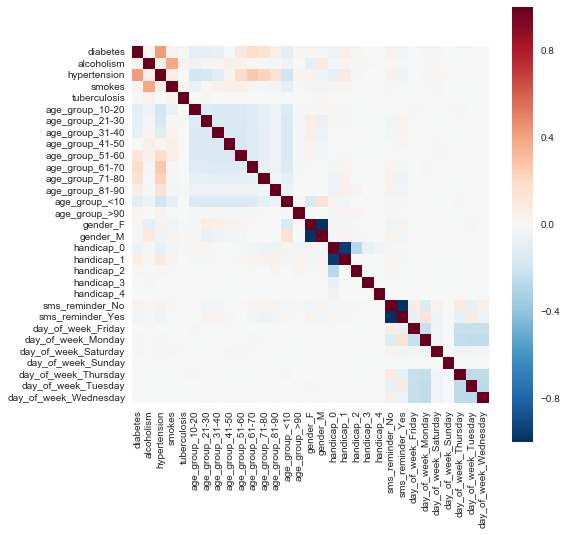

In [284]:
#Checking for correlations between input variables.
plt.figure(figsize = (8,8))
sns.heatmap(corr,vmax=1,square=True)

In [285]:
#Dropping columns that are highly correlated.
col_del = ['gender_M','handicap_0','sms_reminder_No','day_of_week_Saturday','age_group_<10']
X_d.drop(col_del, axis=1, inplace=True)

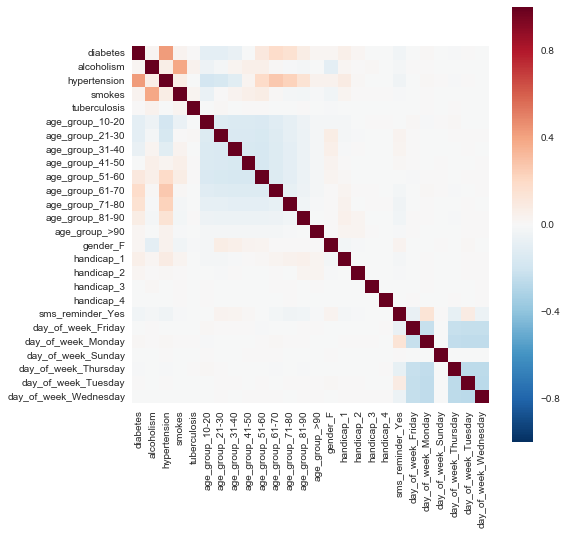

In [286]:
#Ensuring that there are no more high correlations.
corr = X_d.corr()
plt.figure(figsize = (8,8))
sns.heatmap(corr,vmax=1,square=True)

In [287]:
#Scaling input variables for linear models because Age is in a different scale.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_d)
X_Mscaled = scaler.transform(X_d)

In [288]:
#Scaling input variables for linear models because Age is in a different scale.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_d)
X_Sscaled = scaler.transform(X_d)

In [289]:
#Using standard scaler for data partition because outlier effect is minimal.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Sscaled,y,random_state=42, stratify=y)

In [290]:
#30% target 1 percentage in training data
y_train.value_counts()

0    156903
1     68022
Name: status, dtype: int64

In [291]:
#30% target 1 percentage in test data
y_test.value_counts()

0    52301
1    22674
Name: status, dtype: int64

In [292]:
#Creating polynomial terms with degree 2 for regression.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [293]:
#Building logistic regression model with C value of 0.01 and checking training and test accuracies.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.01,random_state=0)
logreg.fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.698
Test set score: 0.698


In [294]:
from sklearn import metrics
from math import sqrt
# Make Predictions
logreg_predicted = logreg.predict(X_test)
probas = logreg.predict_proba(X_test)
logreg_preds = probas[:,1]
logreg_fpr, logreg_tpr, logreg_threshold = metrics.roc_curve(y_test, logreg_preds)

In [295]:
#Building polynomial logistic regression model with C value of 10 and checking training and test accuracies.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10,random_state=0)
logreg.fit(X_train_poly,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_poly, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_poly, y_test)))

Training set score: 0.698
Test set score: 0.698


In [296]:
#Building Random Forest model and checking training and test accuracies.
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50,max_depth=40,random_state=0)
rfc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))

Training set score: 0.701
Test set score: 0.695


In [297]:
# Make Predictions
rfc_predicted = rfc.predict(X_test)
probas = rfc.predict_proba(X_test)
rfc_preds = probas[:,1]
rfc_fpr, rfc_tpr, rfc_threshold = metrics.roc_curve(y_test, rfc_preds)

In [298]:
#Building Decision Tree model and checking training and test accuracies.
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(dtc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtc.score(X_test, y_test)))

Training set score: 0.701
Test set score: 0.695


In [299]:
# Top 5 most important features
print ("Feature Importance (Top 5): ")
print (pd.DataFrame(dtc.feature_importances_, columns = ["Imp"], index = X_d.columns).sort_values(['Imp'], ascending = False).head(5))

Feature Importance (Top 5): 
                       Imp
age_group_61-70   0.121350
age_group_71-80   0.111464
age_group_51-60   0.106669
sms_reminder_Yes  0.064873
gender_F          0.062523


In [300]:
# Make Predictions
dtc_predicted = dtc.predict(X_test)
probas = dtc.predict_proba(X_test)
dtc_preds = probas[:,1]
dtc_fpr, dtc_tpr, dtc_threshold = metrics.roc_curve(y_test, dtc_preds)

In [301]:
#Building MLP Neural network model and checking training and test accuracies.
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)
print("Training set score: {:.3f}".format(mlp.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mlp.score(X_test, y_test)))

Training set score: 0.699
Test set score: 0.697


In [302]:
# Make Predictions
mlp_predicted = mlp.predict(X_test)
probas = mlp.predict_proba(X_test)
mlp_preds = probas[:,1]
mlp_fpr, mlp_tpr, mlp_threshold = metrics.roc_curve(y_test, mlp_preds)

In [303]:
#Building Gaussian Naive Bayes algorithm for classification
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
print("Training set score: {:.3f}".format(gnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(gnb.score(X_test, y_test)))

Training set score: 0.488
Test set score: 0.487


In [304]:
# Make Predictions
gnb_predicted = gnb.predict(X_test)
probas = gnb.predict_proba(X_test)
gnb_preds = probas[:,1]
gnb_fpr, gnb_tpr, gnb_threshold = metrics.roc_curve(y_test, gnb_preds)

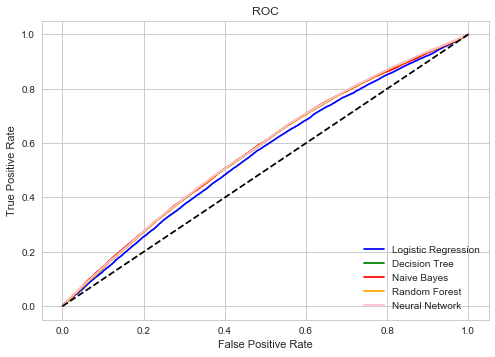

In [305]:
#Model Comparison    
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression', color='blue')
plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree', color='green')
plt.plot(gnb_fpr, gnb_tpr, label='Naive Bayes', color='red')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest', color='orange')
plt.plot(mlp_fpr, mlp_tpr, label='Neural Network', color='pink')
plt.plot([0, 1], [0, 1],'r--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")